In [ ]:
!pip install torch torchvision

In [ ]:
!pip install d2l==0.17.5

In [1]:
!pip install matplotlib-inline

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [1]:
import torch
from torch import nn
from d2l import torch as d2l

To start, we load the WikiText-2 dataset as minibatches of pretraining examples for masked language modeling and next sentence prediction. 

The batch size is 512 and the maximum length of a BERT input sequence is 64. 

Note that in the original BERT model, the maximum length is 512.

In [2]:
batch_size, max_len = 512, 64
train_iter, vocab = d2l.load_data_wiki(batch_size, max_len)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


### Pretraining BERT

The original BERT has two versions of different model sizes. 

The base model ($\text{BERT}_{\text{BASE}}$) uses 12 layers (transformer encoder blocks) with 768 hidden units (hidden size) and 12 self-attention heads. 

The large model ($\text{BERT}_{\text{LARGE}}$) uses 24 layers with 1024 hidden units and 16 self-attention heads. 

Notably, the former has 110 million parameters while the latter has 340 million parameters. 

For demonstration with ease, we define a small BERT, using 2 layers, 128 hidden units, and 2 self-attention heads.

In [3]:
net = d2l.BERTModel(len(vocab), num_hiddens=128, norm_shape=[128],
                    ffn_num_input=128, ffn_num_hiddens=256, num_heads=2,
                    num_layers=2, dropout=0.2, key_size=128, query_size=128,
                    value_size=128, hid_in_features=128, mlm_in_features=128,
                    nsp_in_features=128)
devices = d2l.try_all_gpus()
loss = nn.CrossEntropyLoss()

We define a helper function _get_batch_loss_bert. Given the shard of training examples, this function computes the loss for both the masked language modeling and next sentence prediction tasks. 

Note that the final loss of BERT pretraining is just the sum of both the masked language modeling loss and the next sentence prediction loss.

In [5]:
def _get_batch_loss_bert(net, loss, vocab_size, tokens_X,
                         segments_X, valid_lens_x,
                         pred_positions_X, mlm_weights_X,
                         mlm_Y, nsp_y):
    # Forward pass
    _, mlm_Y_hat, nsp_Y_hat = net(tokens_X, segments_X,
                                  valid_lens_x.reshape(-1),
                                  pred_positions_X)
    # Compute masked language model loss
    mlm_l = loss(mlm_Y_hat.reshape(-1, vocab_size), mlm_Y.reshape(-1)) *\
    mlm_weights_X.reshape(-1, 1)
    mlm_l = mlm_l.sum() / (mlm_weights_X.sum() + 1e-8)
    # Compute next sentence prediction loss
    nsp_l = loss(nsp_Y_hat, nsp_y)
    l = mlm_l + nsp_l
    return mlm_l, nsp_l, l

Training BERT can take very long. Instead of specifying the number of epochs, the input num_steps of the following function specifies the number of iteration steps for training.

In [6]:
def train_bert(train_iter, net, loss, vocab_size, devices, num_steps):
    net = nn.DataParallel(net, device_ids=devices).to(devices[0])
    trainer = torch.optim.Adam(net.parameters(), lr=0.01)
    step, timer = 0, d2l.Timer()
    animator = d2l.Animator(xlabel='step', ylabel='loss',
                            xlim=[1, num_steps], legend=['mlm', 'nsp'])
    # Sum of masked language modeling losses, sum of next sentence prediction
    # losses, no. of sentence pairs, count
    metric = d2l.Accumulator(4)
    num_steps_reached = False
    while step < num_steps and not num_steps_reached:
        for tokens_X, segments_X, valid_lens_x, pred_positions_X,\
            mlm_weights_X, mlm_Y, nsp_y in train_iter:
            tokens_X = tokens_X.to(devices[0])
            segments_X = segments_X.to(devices[0])
            valid_lens_x = valid_lens_x.to(devices[0])
            pred_positions_X = pred_positions_X.to(devices[0])
            mlm_weights_X = mlm_weights_X.to(devices[0])
            mlm_Y, nsp_y = mlm_Y.to(devices[0]), nsp_y.to(devices[0])
            trainer.zero_grad()
            timer.start()
            mlm_l, nsp_l, l = _get_batch_loss_bert(
                net, loss, vocab_size, tokens_X, segments_X, valid_lens_x,
                pred_positions_X, mlm_weights_X, mlm_Y, nsp_y)
            l.backward()
            trainer.step()
            metric.add(mlm_l, nsp_l, tokens_X.shape[0], 1)
            timer.stop()
            animator.add(step + 1,
                         (metric[0] / metric[3], metric[1] / metric[3]))
            step += 1
            if step == num_steps:
                num_steps_reached = True
                break

    print(f'MLM loss {metric[0] / metric[3]:.3f}, '
          f'NSP loss {metric[1] / metric[3]:.3f}')
    print(f'{metric[2] / timer.sum():.1f} sentence pairs/sec on '
          f'{str(devices)}')

MLM loss 5.799, NSP loss 0.784
3628.3 sentence pairs/sec on [device(type='cuda', index=0)]


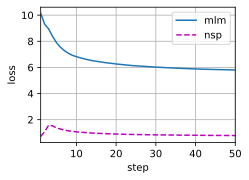

In [7]:
train_bert(train_iter, net, loss, len(vocab), devices, 50)

### Representing Text with BERT

In [8]:
def get_bert_encoding(net, tokens_a, tokens_b=None):
    tokens, segments = d2l.get_tokens_and_segments(tokens_a, tokens_b)
    token_ids = torch.tensor(vocab[tokens], device=devices[0]).unsqueeze(0)
    segments = torch.tensor(segments, device=devices[0]).unsqueeze(0)
    valid_len = torch.tensor(len(tokens), device=devices[0]).unsqueeze(0)
    encoded_X, _, _ = net(token_ids, segments, valid_len)
    return encoded_X

In [12]:
tokens_a = ['a', 'crane', 'is', 'flying']
encoded_text = get_bert_encoding(net, tokens_a)
encoded_text_crane = encoded_text[:, 2, :]
encoded_text_crane

tensor([[ 1.8491e-01,  9.4031e-02, -1.3754e-01,  8.9977e-01,  5.1212e-01,
          7.6487e-01,  7.5291e-01,  1.0813e+00, -3.9109e-01, -1.7262e+00,
          1.1371e+00,  3.9138e-01, -8.7792e-02,  1.0639e+00, -1.7789e+00,
         -1.7404e+00, -3.1525e-02,  5.9484e-02, -8.2904e-01,  6.9561e-01,
          3.6946e-01,  2.4117e+00,  7.3023e-02, -7.1874e-02, -6.2941e-01,
         -2.5351e+00,  1.0385e-01, -1.3251e-02, -2.1859e-01, -7.7336e-01,
          2.8516e-01,  2.3462e-03, -1.3315e+00, -4.1965e-02,  4.1316e-01,
         -2.1321e+00,  1.0013e-01, -4.2977e-01, -3.0817e-01, -2.9036e-01,
          1.3693e+00, -6.4945e-01,  8.9087e-02,  5.3439e-02, -2.7327e+00,
          1.8734e+00,  6.7252e-02,  2.2628e+00, -2.3071e-01,  2.6222e+00,
         -2.3476e+00,  5.2598e-02, -2.6608e+00, -1.5708e-03, -2.1001e+00,
          2.0009e-01,  5.1439e-02, -2.2278e-02, -4.3064e-02,  1.5828e+00,
          2.1375e+00, -9.6572e-02, -1.7682e-01, -1.5947e-01, -1.3231e+00,
         -1.8290e+00,  1.4064e+00, -5.

In [13]:
encoded_text_crane[0][:3]

tensor([ 0.1849,  0.0940, -0.1375], device='cuda:0', grad_fn=<SliceBackward0>)

In [14]:
tokens_b = ['a', 'crane', 'driver', 'came']
encoded_text = get_bert_encoding(net, tokens_b)
encoded_text_crane = encoded_text[:, 2, :]
encoded_text_crane

tensor([[-1.5274e-02, -2.4327e-01, -1.8245e-01,  8.3138e-01,  1.0683e-01,
          7.5658e-01,  1.0516e-01,  1.0723e+00, -4.8387e-01, -1.7324e+00,
          1.0688e+00,  3.7205e-01, -1.2328e-01,  9.9575e-01, -1.7973e+00,
         -6.6317e-02, -2.7153e-02, -1.1270e-02, -3.9876e-02,  4.1804e-02,
          3.2146e-01,  2.4050e+00,  6.9925e-01, -9.3058e-01, -6.5930e-01,
         -2.5881e+00,  1.1732e+00, -6.7283e-02, -3.0816e-01, -8.1209e-01,
          2.2202e-01, -7.2693e-01, -1.3883e+00, -1.1179e-01,  4.1482e-01,
         -2.1979e+00,  3.3043e-02, -4.4665e-01, -3.9133e-01, -1.2534e-02,
          1.3141e+00, -6.4294e-01,  4.9828e-01,  5.1626e-02, -2.7746e+00,
          1.8312e+00,  7.4633e-01,  2.1507e+00, -2.0976e-01,  2.5868e+00,
         -2.4590e+00,  7.5140e-01, -2.6945e+00, -4.4417e-02, -2.1013e+00,
          1.6694e-01,  1.5077e-02, -1.5705e+00, -1.7358e-02,  1.5708e+00,
          2.1017e+00, -1.6762e-01, -3.1355e-02, -2.1563e+00, -1.3645e+00,
         -1.8475e+00,  1.3835e+00, -6.

In [15]:
encoded_text_crane[0][:3]

tensor([-0.0153, -0.2433, -0.1824], device='cuda:0', grad_fn=<SliceBackward0>)